# <img style="float: left; padding-right: 10px; width: 45px" src="style/iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: **Rener de Souza Oliveira**

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [3]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,-116.125000,-163.350000,-9.125000,209.075000,-250.325000,-379.925000,-118.775000,-195.42500,82.850000,...,185.175000,641.250000,-14.800000,419.175000,-31.400000,818.875000,283.850000,11.425000,491.450000,-32.750000
std,0.49029,102.783364,95.437871,101.998539,111.000205,107.218776,123.026449,304.307494,100.91654,99.683743,...,87.141173,305.573085,92.745088,394.131039,54.429818,458.186178,197.123227,36.221461,653.148075,37.159221
min,0.00000,-476.000000,-531.000000,-168.000000,-24.000000,-496.000000,-696.000000,-1038.000000,-452.00000,-148.000000,...,42.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-100.000000,-33.000000,-108.000000
25%,0.00000,-140.750000,-208.500000,-81.250000,124.250000,-316.500000,-461.750000,-269.250000,-238.50000,-0.250000,...,133.750000,424.500000,-57.250000,241.750000,-57.250000,540.000000,189.000000,-8.250000,151.000000,-62.750000
50%,0.00000,-109.000000,-150.000000,-29.000000,228.000000,-225.000000,-384.500000,-77.000000,-172.00000,99.000000,...,179.500000,619.000000,10.500000,343.000000,-21.000000,747.000000,282.000000,10.000000,242.000000,-30.500000
75%,1.00000,-64.750000,-99.500000,47.000000,303.750000,-178.750000,-286.250000,20.500000,-125.75000,164.500000,...,227.000000,728.000000,52.250000,475.750000,11.250000,1042.500000,351.750000,28.250000,536.000000,-12.750000
max,1.00000,86.000000,-20.000000,262.000000,431.000000,-32.000000,-122.000000,367.000000,-11.00000,283.000000,...,413.000000,1655.000000,132.000000,2527.000000,50.000000,2313.000000,1108.000000,81.000000,3192.000000,78.000000


In [4]:
def min_max_scale(data,cols):
    df = data.copy()
    for col in cols:
        min_ = df[col].min()
        max_ = df[col].max()
        df.loc[:,col] = (df[col]-min_)/(max_-min_)
    return df

df_train = min_max_scale(data_train,data_train.columns[1:])
df_test = min_max_scale(data_test,data_test.columns[1:])
df_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.49029,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.00000,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,1.00000,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


----
Reference: Lecture 14, CS109A
- Matrices may note be invertible which is a problem to linear regression
- It's more likely to have multicollinearity
- It's more easy to overfit the model
- We can generate much more predictors than we have, consideraing power and interaction terms, highlighting the above issues.

----

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

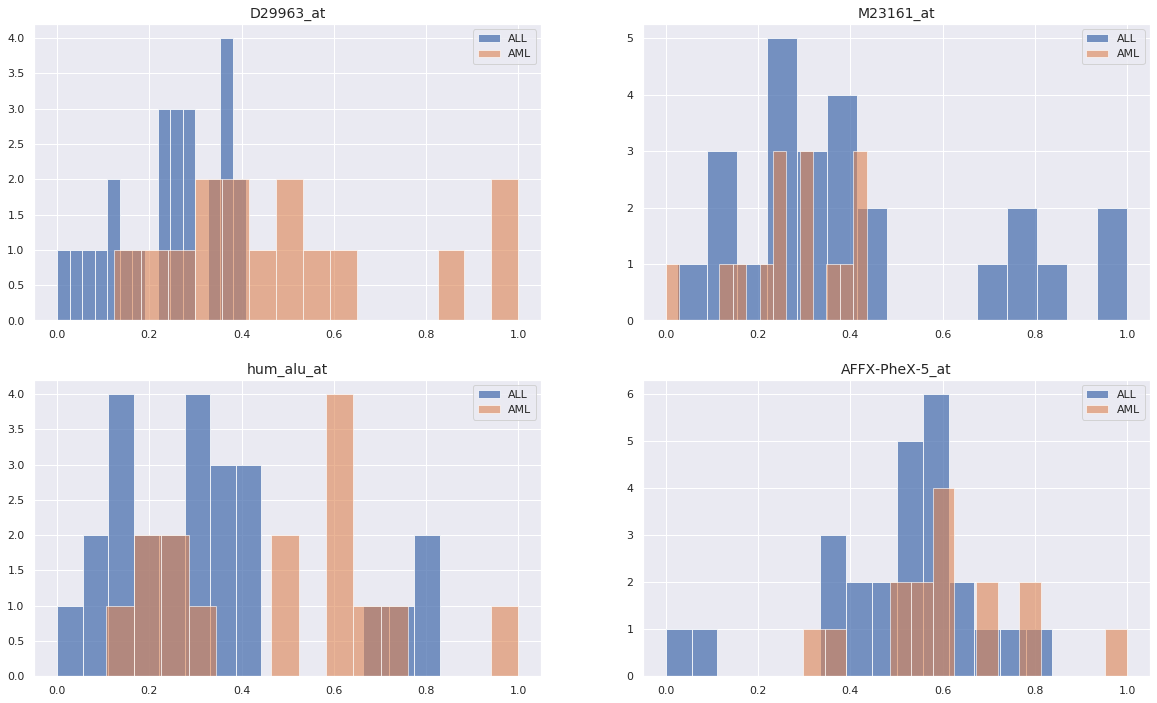

In [5]:
genes = ['D29963_at','M23161_at','hum_alu_at','AFFX-PheX-5_at']
fig,ax = plt.subplots(2,2,figsize=(20,12))

for i in range(0,len(genes)):
    ax[i//2][i%2].set_title(genes[i],fontsize=14)
    ax[i//2][i%2].hist(x=df_train[df_train['Cancer_type']==0][genes[i]],alpha=0.75,label = "ALL",bins=15)
    ax[i//2][i%2].hist(x=df_train[df_train['Cancer_type']==1][genes[i]],alpha=0.6,label = "AML",bins=15)
    ax[i//2][i%2].legend(loc='best')
    


----
It doesn't appear that any of these genes discriminate between the two classes well. The two histograms overlay a lot. The better one was D29963_at, where the overlaying is more controlled and with a little error, we can set a threshold for separate the classes.

----

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

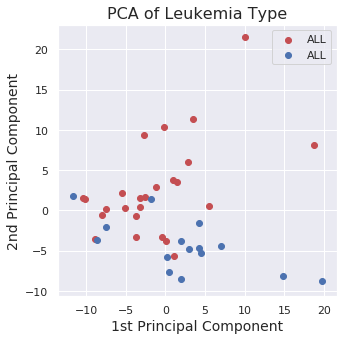

In [6]:
x_train = df_train[df_train.columns[1:]].set_index(np.arange(0,len(df_train)))
y_train = pd.DataFrame(df_train['Cancer_type'],columns=['Cancer_type']).set_index(np.arange(0,len(df_train)))
x_test = df_test[df_test.columns[1:]].set_index(np.arange(0,len(df_test)))
y_test = pd.DataFrame(df_test['Cancer_type'],columns=['Cancer_type']).set_index(np.arange(0,len(df_test)))

pca_transformer = PCA(2).fit(x_train)
x_train_pca = pd.DataFrame(pca_transformer.transform(x_train),columns=[['PCA1','PCA2']])
x_test_pca =  pd.DataFrame(pca_transformer.transform(x_test),columns=[['PCA1','PCA2']])

var = pca_transformer.explained_variance_ratio_

#Reference: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xlabel('1st Principal Component',fontsize=14)
ax.set_ylabel('2nd Principal Component',fontsize=14)
ax.set_title("PCA of Leukemia Type",fontsize=16)
targets = {0:'ALL', 1:'AML'}
index_0 = y_train == 0
index_0 = y_train.loc[index_0['Cancer_type'],:].index
index_1 = y_train == 1
index_1 = y_train.loc[index_1['Cancer_type'],:].index
ax.scatter(x_train_pca[x_train_pca.index.isin(index_0)].loc[:,['PCA1']]
               ,x_train_pca[x_train_pca.index.isin(index_0)].loc[:,['PCA2']], c = 'r',label = "ALL")
ax.scatter(x_train_pca[x_train_pca.index.isin(index_1)].loc[:,['PCA1']]
               ,x_train_pca[x_train_pca.index.isin(index_1)].loc[:,['PCA2']], c = 'b',label = "ALL")

ax.legend(loc='best');

y_train = np.array(y_train['Cancer_type']).reshape(-1,1)
y_test = np.array(y_test['Cancer_type']).reshape(-1,1)

In [7]:
print(f"2 Principal Components Explainded Variance Ratio = {var.sum()}")

2 Principal Components Explainded Variance Ratio = 0.2731782945208865


----
The 2 principal components have explained variance of $\approx 27,3\%$. And as we can see in the plot, the two classes of cancer are well discriminated, although with some confusion still.

----

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [8]:
x_train_d29 = sm.add_constant(x_train['D29963_at'])
lin_model = sm.OLS(y_train,x_train_d29).fit()

----
The problem with interpreting predicted values of linear regression as probabilities is that we can have values outside the interval $[0,1]$

----


**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [9]:
x_test_d29 = sm.add_constant(x_test['D29963_at'])
y_pred_train = np.array(lin_model.predict(x_train_d29)>0.5).reshape(-1,1)
y_pred_test = np.array(lin_model.predict(x_test_d29)>0.5).reshape(-1,1)

acc_train = np.sum(y_pred_train == y_train)/len(y_train)
acc_test = np.sum(y_pred_test == y_test)/len(y_test)
print("Training Accuracy = {:.3f}\nTest Accuracy = {:.3f}".format(acc_train,acc_test))

Training Accuracy = 0.800
Test Accuracy = 0.788


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [10]:
x_train_d29 = np.array(x_train_d29['D29963_at']).reshape(-1,1)
x_test_d29 = np.array(x_test_d29['D29963_at']).reshape(-1,1)
logit_model = LogisticRegression(C=100000,fit_intercept=True).fit(x_train_d29,y_train.ravel())

y_pred_train = np.array(logit_model.predict(x_train_d29)).reshape(-1,1)
y_pred_test = np.array(logit_model.predict(x_test_d29)).reshape(-1,1)

acc_train = np.sum(y_pred_train == y_train)/len(y_train)
acc_test = np.sum(y_pred_test == y_test)/len(y_test)
print("Training Accuracy = {:.3f}\nTest Accuracy = {:.3f}".format(acc_train,acc_test))


Training Accuracy = 0.800
Test Accuracy = 0.697


----
In the training set we got the same accuracy on both linear and logistic regression.

In the test set, the logistic accuracy was lower than the linear one. 

----


**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

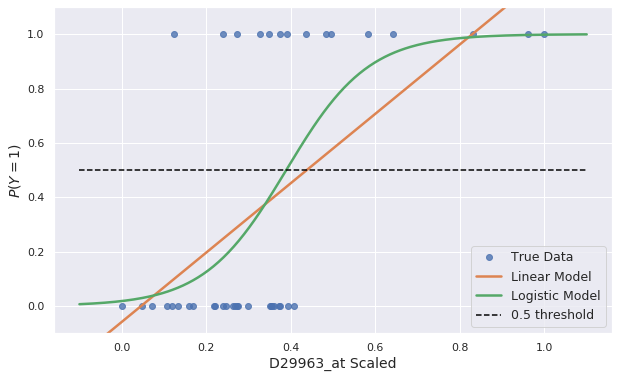

In [11]:
def get_prob(b0,b1,x):
    logit = b0 + b1*x
    odds = np.exp(logit)
    return odds/(1+odds)

b1 = logit_model.coef_[0][0]
b0 = logit_model.intercept_[0]

plt.figure(figsize=(10,6))
plt.plot(x_train_d29, y_train, 'o', alpha=0.8,label = "True Data")
plt.ylim(-0.1,1.1)
plt.xlabel("D29963_at Scaled",fontsize = 14)
plt.ylabel(r"$P(Y=1)$",fontsize = 14)
x=np.linspace(-0.1,1.1,num=300) #Range of predictor values +- 0.1
plt.plot(x,lin_model.predict(sm.add_constant(x)),lw=2.5,label = "Linear Model")
plt.plot(x,get_prob(b0,b1,x),lw=2.5,label = "Logistic Model")
plt.plot(x,np.ones(x.shape)/2,'--',color='black',label = "0.5 threshold")
plt.legend(loc="best",fontsize = 12.5);

----
Based on the plot, neither linear nor logistic model appears do be better upon the other. The explanation is that, considering the classification threshold of 0.5, the difference between the two classifiers would be minimal.

----

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [12]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0',alpha=0.7)
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1',alpha=0.7)
    

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
#     print(npos,nneg)
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [13]:
reg = LogisticRegression(C=100000,fit_intercept=True)
multi_logit_model = reg.fit(x_train,y_train.ravel())
y_pred_train = np.array(multi_logit_model.predict(x_train)).reshape(-1,1)
y_pred_test = np.array(multi_logit_model.predict(x_test)).reshape(-1,1)

acc_train = np.sum(y_pred_train == y_train)/len(y_train)
acc_test = np.sum(y_pred_test == y_test)/len(y_test)
print("Training Accuracy = {:.3f}\nTest Accuracy = {:.3f}".format(acc_train,acc_test))

Training Accuracy = 1.000
Test Accuracy = 0.970


----
The accuracy of both training and test sets increased a lot. The training one now is one, and the test is 0.97, also very high.


----

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

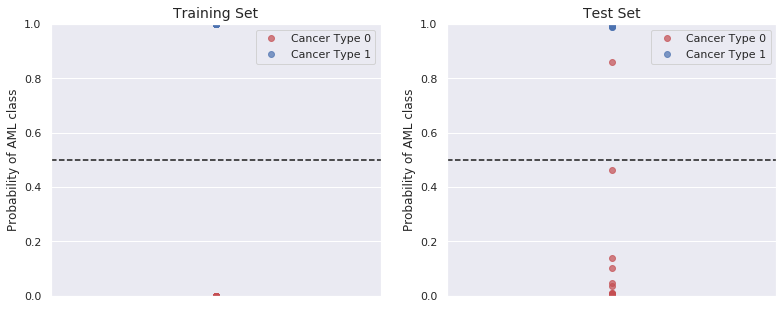

In [14]:
fig,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].set_title("Training Set",fontsize=14)
ax[1].set_title("Test Set",fontsize=14)
visualize_prob(reg, x_train, y_train.ravel(), ax[0])
visualize_prob(reg, x_test, y_test.ravel(), ax[1])

----
The training set probabilities are very well defined as 0 or 1 (it seems that just one point is wrongly classified), but the test set probs, are more spread out.

The is a point in the test set, with the predicted probability very close to 0.5, just a little lower. The uncertanty of the classification are higher here, because a $\approx50\%$ chance for each class, we could just flip a coin to decide, instead of trust the value and threshold.


----

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [15]:
from scipy.stats import norm as z

#Code from HW4
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    if not size: size = len(dataset_X)
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
        
    df = pd.concat([dataset_X,pd.DataFrame(dataset_y,columns = ['y'])],axis=1)
    bs_df = df.sample(n=size,replace=True,axis=0)
    
    bootstrap_dataset_X = bs_df.loc[:,dataset_X.columns]
    bootstrap_dataset_y = np.array(bs_df.y).reshape(-1,1)
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)

def calculate_coefficients(dataset_X, dataset_y, model):
    
    logit = model.fit(dataset_X,dataset_y.ravel())
    coefficients_dictionary = {}
    for i,param in enumerate(dataset_X.columns):
        coefficients_dictionary[param] = logit.coef_[0][i]
        
    return coefficients_dictionary

def get_significant_predictors(regression_coefficients, sig_level=0.05):
    significant_coefficients = []
    #n = len(X_train)
    coefs = regression_coefficients[0]
    for param in regression_coefficients[0].keys():
        boot_sample = np.array([k[param] for k in regression_coefficients])
        mean = boot_sample.mean()
        s = boot_sample.std()
        z_stat = mean/s
        p = (1-z.cdf(abs(z_stat)))*2
        if p < sig_level:
            significant_coefficients.append(param)
    return significant_coefficients

coef_list = []
for _ in range(1000):
    x_bs,y_bs = make_bootstrap_sample(x_train,y_train)
    coef = calculate_coefficients(x_bs, y_bs, reg)
    coef_list.append(coef)
sig_features = get_significant_predictors(coef_list)

In [16]:
print("{} significant features out of {}".format(len(sig_features),x_train.shape[1]))

1702 significant features out of 7129


## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [17]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

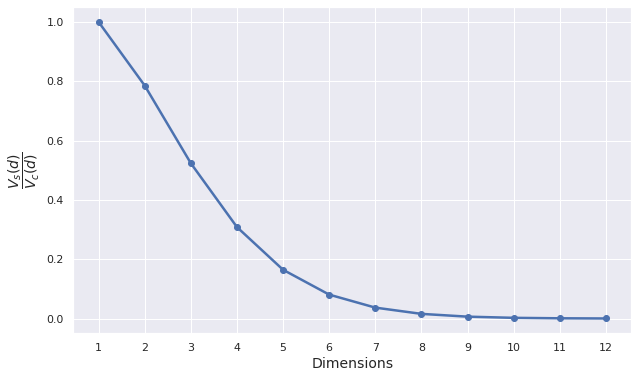

In [18]:
d = np.arange(1,13)
ratio = V_s(d)/V_c(d)

plt.figure(figsize=(10,6))
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel(r"$\dfrac{V_s(d)}{V_c(d)}$",fontsize=14)
plt.xticks(d)
plt.plot(d,ratio,'-o',lw=2.5);

----
1. We want to compute $\dfrac{V_s(d)}{V_c(d)}$; Using $V_c(d) = 2^d$ and $V_s(d) = \dfrac{\pi^\frac{d}2}{\Gamma(\frac{d}{2}+1)}$, we have:

$\dfrac{V_s(d)}{V_c(d)} = \dfrac{\pi^\frac{d}2}{2^d\Gamma(\frac{d}{2}+1)}$

The above expression shows us, as a function of $d$ how much of the hypercube's volume is contained within the hypersphere.

2. As $d$ goes to infinity, $\pi^{\frac{d}{2}}$ grows asymptotically slower than $2^d$, this can be easily prove by induction in $d$ since $d\in\mathbb{N}$. So $\lim_{d\to\infty}\dfrac{\pi^{\frac{d}{2}}}{2^d}=0$. 

Since Gamma is an increasing function, $\lim_{d\to\infty}\dfrac{\pi^{\frac{d}{2}}}{2^d\Gamma(\frac{d}{2}+1)}$ also goes to  0.

3. In the above plot, we can visualize the limit.

4. The limit and the plot, tells us the majority of the volume of the hypercube in higher dimensions resides outside the hypersphere. We can see mentally this trend in 1D, 2D, and 3D, but higher than that, we have to analyze as we did above.

----

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

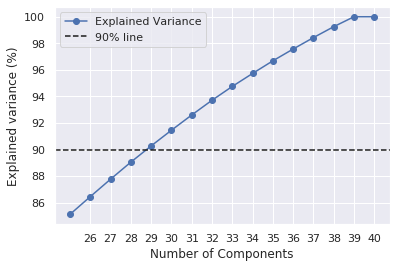

In [19]:
pca_transformer = PCA().fit(x_train)
x_train_pca = pca_transformer.transform(x_train)
x_test_pca =  pca_transformer.transform(x_test)

var = pca_transformer.explained_variance_ratio_*100
n = np.arange(1,len(var)+1)
exp_var = pd.DataFrame(np.array([n,np.cumsum(var)]).T,columns = ['Components','Explained Variance']).set_index('Components')
plt.plot(exp_var[25:],'-o',label = "Explained Variance")
plt.xticks(exp_var.index[25:]);
plt.axhline(y=90,color = 'k',ls='--',label = "90% line")
plt.xlabel("Number of Components")
plt.ylabel("Explained variance (%)")
plt.legend(loc='best')
plt.show()

In [20]:
print(exp_var.iloc[28,:],end="\n\n")
x_train_pca = pd.DataFrame(x_train_pca[:,0:29],columns = ["PCA_"+str(x) for x in range(1,30)])
x_test_pca = pd.DataFrame(x_test_pca[:,0:29],columns = ["PCA_"+str(x) for x in range(1,30)])
pca_reg = LogisticRegression(C=100000,fit_intercept=True)
pca_model = pca_reg.fit(x_train_pca,y_train.ravel())

y_pred_train = np.array(pca_model.predict(x_train_pca)).reshape(-1,1)
y_pred_test = np.array(pca_model.predict(x_test_pca)).reshape(-1,1)

acc_train_pca = accuracy_score(y_train,y_pred_train)
acc_test_pca = accuracy_score(y_test,y_pred_test)
print("PCA Training Accuracy = {:.3f}\nPCA Test Accuracy = {:.3f}".format(acc_train_pca,acc_test_pca))

Explained Variance    90.268704
Name: 29.0, dtype: float64

PCA Training Accuracy = 1.000
PCA Test Accuracy = 0.909


----
We need $29$ components to capture at least $90%$ of explained variance, and the actual variance is $\approx 90.27\%$

In question 3.1 the training accuracy was 1 (same as PCA Regression now) and the test one was 0.970, while now, we got 0.909.

The loss in test accuracy can be explained by the components we selected. 29 out of 40, can reduce a little, the predictive ability of the model when exposed to data never saw before.

The perfect accuracy of 1, on both training sets of question 3.1 and now, can be explained by the low number of lines in our dataset compared to a large number of predictors. Even using PCA, we're coding almost the same information as before with 90% explained variance. So, overfitting is inevitable here.

----

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

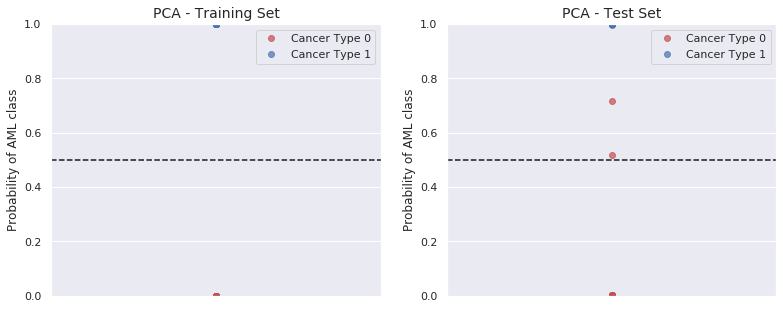

In [21]:
fig,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].set_title("PCA - Training Set",fontsize=14)
ax[1].set_title("PCA - Test Set",fontsize=14)
visualize_prob(pca_reg, x_train_pca, y_train.ravel(), ax[0])
visualize_prob(pca_reg, x_test_pca, y_test.ravel(), ax[1])

----
Although we have simillar predictive power in PCR comparing to direct logistic regression, working with PCA reduces computational time, since it reduces multicollinearity, and avoids somes of those problems highlighted in question 1.3.

----


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [22]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

x_train = data_train[['Biomarker 1','Biomarker 2']]
y_train = data_train['Diagnosis']
x_test = data_test[['Biomarker 1','Biomarker 2']]
y_test = data_test['Diagnosis']
data_train.describe()

,Biomarker 1,Biomarker 2,Diagnosis
count,102.000000,102.000000,102.000000
mean,0.344213,0.136095,1.392157
std,0.830087,2.201512,0.677164
min,-2.302485,-11.512925,1.000000
25%,-0.105349,-1.076236,1.000000
50%,0.222351,0.641859,1.000000
75%,0.470010,1.273894,2.000000
max,4.032469,3.970292,3.000000


**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


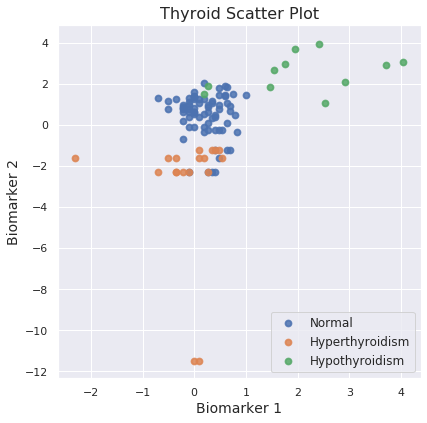

In [23]:
labels = {1:'Normal',2:'Hyperthyroidism',3:'Hypothyroidism'}
fig,ax = plt.subplots(1,1,figsize=(6.5,6.5))
for i in range (1,4):
    index = data_train.Diagnosis == i
    ax.scatter(data_train.loc[index,'Biomarker 1'],data_train.loc[index,'Biomarker 2'],
               lw = 1.75,label = labels[i],alpha=0.85)
ax.legend(loc='best',fontsize=12)
ax.set_xlabel("Biomarker 1",fontsize=14)
ax.set_ylabel("Biomarker 2",fontsize=14)
ax.set_title("Thyroid Scatter Plot",fontsize=16);

----
As we can see above, the data points are well separated. Linear classifiers would fit it satisfactorily.

----

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
In OvR, you simply fit three different models, selecting one predictor as a baseline, and choose the response which yields the highest probability. In Multinomial, one of the 3 outputs would be chosen as a pivot, and the others will be regressed against it through a log of the ratio of the two probabilities, with a little calculation we can reverse back the results to probabilities and make predictions.

----

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [24]:
kf = KFold(n_splits=5)
lambdas = [.001, .0025, .005, 1, 2.5, 5, 10, 25, 50, 100, 250, 500, 1000]
Cs = [1/x for x in lambdas]

ovr_logit = LogisticRegressionCV(Cs=Cs,cv=kf,scoring='accuracy',multi_class = 'ovr').fit(x_train,y_train)
# ovr_logit = LogisticRegression(Cs = ovr_logit_cv.C_, multi_class='ovr').fit(x_train,y_train)
multi_logit = LogisticRegressionCV(Cs=Cs,cv=kf,scoring='accuracy',multi_class = 'multinomial').fit(x_train,y_train)
y_pred_ovr = ovr_logit.predict(x_test)
y_pred_multi = multi_logit.predict(x_test)

print("OvR Accuracy - {:.3f}\nMultinomial Accuracy - {:.3f}"
      .format(accuracy_score(y_test,y_pred_ovr),accuracy_score(y_test,y_pred_multi)))

OvR Accuracy - 0.876
Multinomial Accuracy - 0.885


----
Reference: Lecture 11, CS109A

The multinomial accuracy in the test set is higher than OvR. As said in the reference, multinomial is slightly more efficient since it's formula requires fewer parameters.

----

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


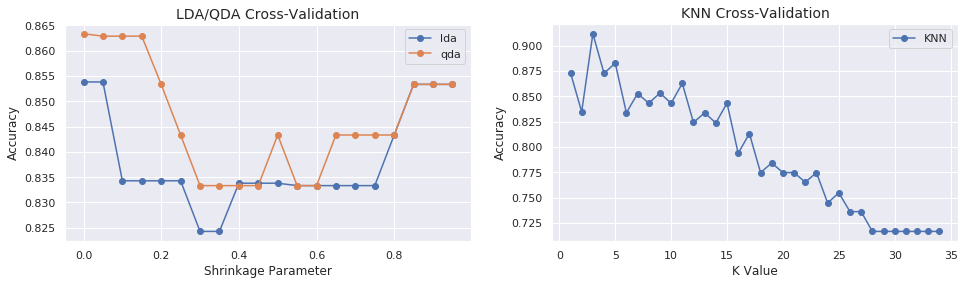

In [25]:

#Predefining the Multiclass Logistic Regression with quadratic terms for usage in next cell
# x_train_squared = x_train.copy()
# x_test_squared = x_test.copy()
poly = PolynomialFeatures(2,include_bias = False)
x_train_squared = pd.DataFrame(poly.fit_transform(x_train))
x_test_squared = pd.DataFrame(poly.fit_transform(x_test))
# for param in x_train.columns:
#     x_train_squared["{}^{}".format(param,2)] = x_train[param]**2
#     x_test_squared["{}^{}".format(param,2)] = x_test[param]**2
multi_logit_squared = LogisticRegressionCV(Cs=Cs,cv=kf,scoring='accuracy',
                                           multi_class = 'multinomial',penalty='l2',
                                           max_iter=300).fit(x_train_squared,y_train)
#Cross Validation with LDA, QDA and KNN
acc_LDA = []
acc_QDA = []
acc_KNN = []

lambda_lda = -1 #best lambda LDA 
lambda_lda = -1 #best lambda QDA 
k_knn = -1 #best k

score_lda = -np.inf 
score_qda = -np.inf 
score_knn = -np.inf

shrink_params = np.arange(0,1,0.05)
neighbors = np.arange(1,35)

for l in shrink_params:
    lda_reg = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=l)
    qda_reg = QuadraticDiscriminantAnalysis(reg_param=l)
    
    acc_lda = cross_val_score(lda_reg, x_train, y_train, cv=kf,scoring='accuracy')
    acc_qda = cross_val_score(qda_reg, x_train, y_train, cv=kf,scoring='accuracy')
    
    acc_LDA.append(acc_lda.mean())
    acc_QDA.append(acc_qda.mean())
   
    
    if acc_lda.mean() > score_lda:
        score_lda = acc_lda.mean()
        lambda_lda = l
    
    if acc_qda.mean() > score_qda:
        score_qda = acc_qda.mean()
        lambda_qda = l
    
for k in neighbors:
    knn_reg = KNeighborsClassifier(n_neighbors=k)
    acc_knn = cross_val_score(knn_reg, x_train, y_train, cv=kf,scoring='accuracy')
    acc_KNN.append(acc_knn.mean())
    if acc_knn.mean() > score_knn:
        score_knn = acc_knn.mean()
        k_knn = k
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(shrink_params,acc_LDA,'-o',label="lda")
ax[0].plot(shrink_params,acc_QDA,'-o',label = "qda")
ax[1].plot(neighbors,acc_KNN,'-o',label = "KNN")
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].set_title("LDA/QDA Cross-Validation",fontsize=14)
ax[1].set_title("KNN Cross-Validation",fontsize=14)
ax[0].set_xlabel("Shrinkage Parameter")
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("K Value")
ax[1].set_ylabel("Accuracy");

In [26]:
#Comparing Models Accuracy
y_pred_sqrd = multi_logit_squared.predict(x_test_squared)
acc_multi_sqrd = accuracy_score(y_test,y_pred_sqrd)
lda_model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=lambda_lda).fit(x_train,y_train)
qda_model = QuadraticDiscriminantAnalysis(reg_param=lambda_qda).fit(x_train,y_train)
knn_model = KNeighborsClassifier(n_neighbors=k_knn).fit(x_train,y_train)

acc_dict = {"Multi Logistic":acc_multi_sqrd,"LDA":lda_model,"QDA":qda_model,"KNN":knn_model}

for key in list(acc_dict.keys())[1:]:
    fitted = acc_dict[key]
    y_pred = fitted.predict(x_test)
    acc_dict[key] = accuracy_score(y_test,y_pred)
    
acc_dict

{'Multi Logistic': 0.9026548672566371,
 'LDA': 0.8407079646017699,
 'QDA': 0.8495575221238938,
 'KNN': 0.8672566371681416}

**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
The first key/value of our accuracy dictionary above represents the Multiclass Logistic Regression with quadratic terms; The accuracy is $\approx 0.903$. In question 7.3, in the regression with only linear terms using the same approach for deal multiclass (multinomial), we got a score of $\approx0.885$. 

So, adding polynomial (and interaction) terms had yielded a slightly better test accuracy.

----

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [27]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

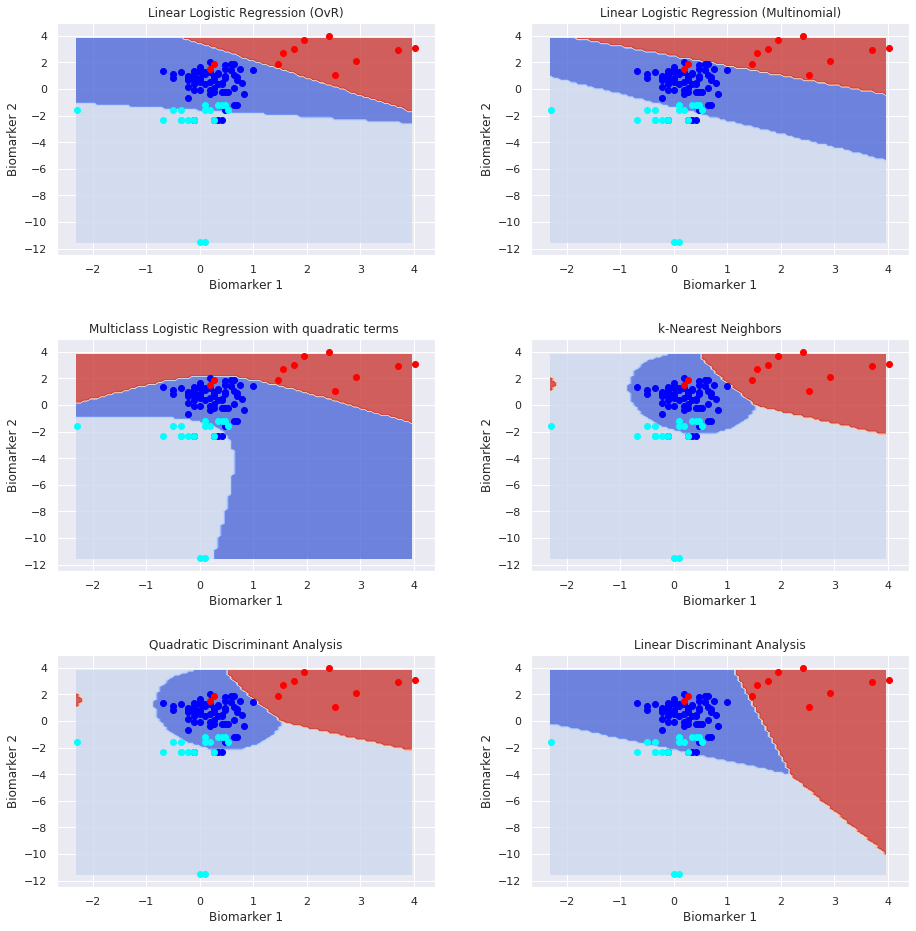

In [28]:
fig,ax = plt.subplots(3,2,figsize=(14,14))
fig.tight_layout(pad=5)
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), ovr_logit,
                       "Linear Logistic Regression (OvR)", ax[0][0])
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), multi_logit,
                       "Linear Logistic Regression (Multinomial)", ax[0][1])
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), multi_logit_squared,
                       "Multiclass Logistic Regression with quadratic terms ", ax[1][0],2)
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), lda_model,
                       "Linear Discriminant Analysis", ax[2][1])
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), qda_model,
                       "Quadratic Discriminant Analysis", ax[2][0])
plot_decision_boundary(x_train.to_numpy(), y_train.to_numpy(), qda_model,
                       "k-Nearest Neighbors", ax[1][1])


**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
__OvR and Multinomial__

The difference is very slight since both methods use linear terms. They differ just by the slopes of the boundaries lines.

__Linear Logistic and LDA__

LDA is misclassifying a lot of blue points, which doesn't happen in Linear Logistic Models. LDA makes some additional assumptions about the distribution of x and y, if the data doesn't fit those assumption,  we can have worse results than Linear Logistic Models which doesn't make any assumption like that.

__QDA__

QDA model is id more general than LDA and can fit itself to the data with non-linear boundaries as we can see above. It's a more flexible model.

---

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---

References: https://scikit-learn.org/stable/modules/lda_qda.html

Both LDA and QDA are derived from a probabilistic model for $P(Y=k|x)$ (posterior). When we apply Bayes Rule, the formula will depend on the prior $P(x|Y=k)$, which is assumed to be multivariate normal distributed.

The LDA model shares the same covariance matrix for all classes ($\forall k$), while QDA uses different correlation matrices for each class to compute $P(x|Y=k)$. The probabilistic formula will then, have a quadratic term on $x$, while the LDA formula is linear.

This explains the differences in the classification boundaries above. QDA is more flexible as we said before since it can include quadratic curves. LDA boundaries are just lines.

---

In [31]:
# !jupyter nbconvert --to PDF "fds_hw5_RENER_OLIVEIRA.ipynb"